In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic

In [92]:
import os
os.getcwd()

'/Users/ruben/Desktop/final-project-repo-team-trust/final-project-repo-team-trust/notebooks'

In [93]:
# %%
# load data
# path

csv_path = "../data/02_BERTopic_results/PoliticalDiscussion_with_vader_bertopic.csv"

import pandas as pd
df = pd.read_csv(csv_path, encoding="latin1")  # latin1 to fix encoding issues
df.head(), df.shape, df.columns


(  kind_comment    subreddit_comment submission_id comment_id   parent_id  \
 0      comment  PoliticalDiscussion        vno7ha    ie8mqxp  t1_ie8cghn   
 1      comment  PoliticalDiscussion        r7koge    hn3va0o  t1_hn0x9q9   
 2      comment  PoliticalDiscussion       18alxnn    kbzsdrs  t1_kbyo70u   
 3      comment  PoliticalDiscussion        ll80ib    gno0rrd  t1_gnnypq7   
 4      comment  PoliticalDiscussion        w3t7de    igye0ka  t1_igyc9or   
 
   is_top_level                                               body  \
 0        FALSE  Positive points for free speech if the cons ca...   
 1        FALSE  Democratic voters elect Democrats to accomplis...   
 2        FALSE  Muslims and Republicans should be a perfect ma...   
 3        FALSE  The Democrats are more popular than Republican...   
 4        FALSE  Yes, in a democratic system non-violent protes...   
 
     author_comment score_comment created_utc_comment  ... author_submission  \
 0            4kray            19 

In [94]:
# doublecheck to clean and remove missing values

df_clean = df.dropna(subset=['topic_id', 'vader_compound']).copy()

df_clean['topic_id'] = df_clean['topic_id'].astype(int)
df_clean['vader_compound'] = pd.to_numeric(df_clean['vader_compound'], errors='coerce')

df_clean = df_clean.dropna(subset=['vader_compound'])

df_clean.shape

(16641, 28)

In [95]:
# Load  BERtopic name summary file

topic_info = pd.read_csv("../data/02_BERTopic_results/bertopic_topic_info_summary.csv")

topic_info.head()



,Topic,Count,Name,Representation,Representative_Docs
0,-1,6698,-1_the_to_and_of,"['the', 'to', 'and', 'of', 'that', 'in', 'it',...","[""Honestly, the apocalyptic talk about Republi..."
1,0,1934,0_the_to_and_they,"['the', 'to', 'and', 'they', 'of', 'that', 'yo...","[""I'm a Democrat but there's some Republicans ..."
2,1,965,1_he_his_trump_him,"['he', 'his', 'trump', 'him', 'the', 'to', 'an...","['No. Despite the bad news, the Republican est..."
3,2,695,2_the_to_it_that,"['the', 'to', 'it', 'that', 'tax', 'and', 'of'...","[""&gt; high tax brackets (over $1 million per ..."
4,3,629,3_he_the_trump_to,"['he', 'the', 'trump', 'to', 'that', 'of', 'it...","[""Apparently the search has to do with 15 boxe..."


In [96]:
# drop stop words from BERTopic topic names so they don't interfere with analysis

topic_info_clean = topic_info[topic_info["Topic"] != -1]

In [97]:
# stopwords list
stopwords = {"the", "to", "and", "of", "it", "his", "her", "they", "he", "she"}

# filter topics
def is_stopword_topic(name):
    words = name.lower().split("_")
    stopword_fraction = sum(w in stopwords for w in words) / len(words)
    return stopword_fraction > 0.5  # remove topics that are at least > 50% stopwords

topic_info_clean = topic_info[~topic_info["Name"].apply(is_stopword_topic)]


In [98]:
# merge topic names with main dataframe

df_merged_clean = df_clean.merge(topic_info_clean, left_on='topic_id', right_on='Topic', how='inner')

topic_sentiment_clean = (
    df_merged_clean
    .groupby(['topic_id', 'Name'])
    .agg(
        n_comments=('vader_compound', 'size'),
        mean_vader=('vader_compound', 'mean'),
        sd_vader=('vader_compound', 'std')
)
    .reset_index()
)

# remove topics with few comments to avoid noise
topic_sentiment_clean = topic_sentiment_clean.query('n_comments >=5')

### Comparison of BERTopics with most negative sentiment according to VADER

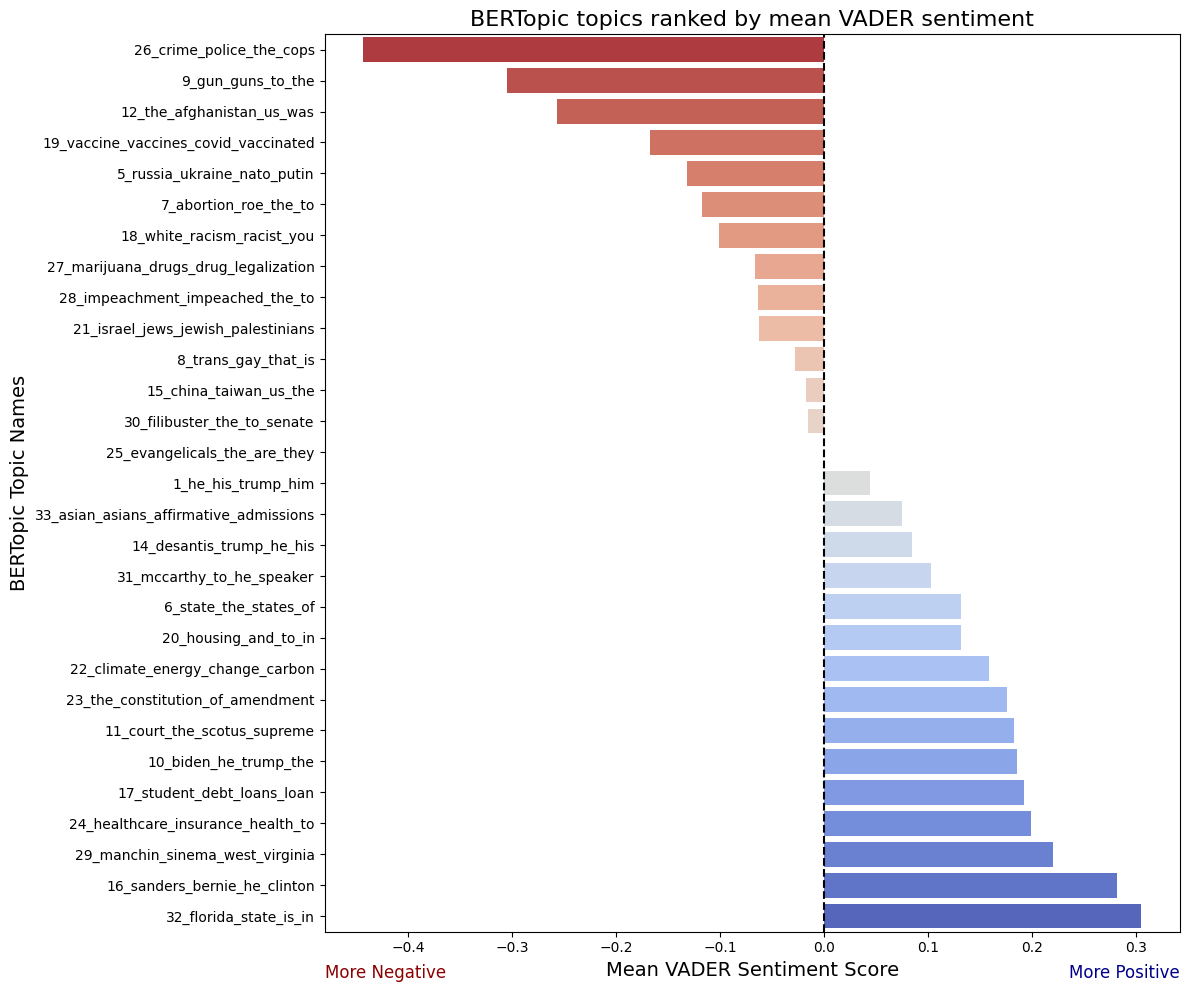

In [99]:
# clean chart with BERTopic names and VADER sentiment

sorted_topics = topic_sentiment_clean.sort_values('mean_vader')

plt.figure(figsize=(12, 10))
sns.barplot(
    data=sorted_topics,
    y='Name',
    x='mean_vader',
    palette='coolwarm_r', # _r to reverse colors
)

plt.axvline(0, linestyle='--', color='black')

# Add labels and title
x_min, x_max = plt.xlim()
plt.text(x_min, 30, 'More Negative', fontsize=12, color='darkred', ha='left')
plt.text(x_max, 30, 'More Positive', fontsize=12, color='darkblue', ha='right')


plt.title('BERTopic topics ranked by mean VADER sentiment', fontsize=16)
plt.xlabel('Mean VADER Sentiment Score', fontsize=14)
plt.ylabel('BERTopic Topic Names', fontsize=14)
plt.tight_layout()
plt.show()


## Polarization score
#### Why is polarization important to measure within misinformation?
#### polarization is the degree to which opinions on a topic are divided into two opposing camps.
#### A high polarization score indicates that a topic elicits strong, divergent opinions among individuals, leading to a clear split in viewpoints.
#### Conversely, a low polarization score suggests that opinions on the topic are more homogeneous, with individuals generally agreeing or holding similar views.

In [101]:
# polarization score

topic_sentiment_clean['polarization'] = topic_sentiment_clean['sd_vader']

# most emotionally polarized topics
polarized_topics = topic_sentiment_clean.sort_values(
    'polarization',
    ascending=False
)

polarized_topics[['topic_id', 'Name', 'n_comments', 'mean_vader', 'polarization']].head(10)

,topic_id,Name,n_comments,mean_vader,polarization
28,33,33_asian_asians_affirmative_admissions,56,0.074957,0.712420
26,31,31_mccarthy_to_he_speaker,57,0.103216,0.672869
9,14,14_desantis_trump_he_his,207,0.085046,0.648825
10,15,15_china_taiwan_us_the,203,-0.017752,0.640980
13,18,18_white_racism_racist_you,180,-0.101288,0.622347
16,21,21_israel_jews_jewish_palestinians,122,-0.062724,0.621947
1,5,5_russia_ukraine_nato_putin,499,-0.132092,0.619161
11,16,16_sanders_bernie_he_clinton,200,0.281179,0.617016
22,27,27_marijuana_drugs_drug_legalization,83,-0.066348,0.607944
4,8,8_trans_gay_that_is,321,-0.027953,0.604451


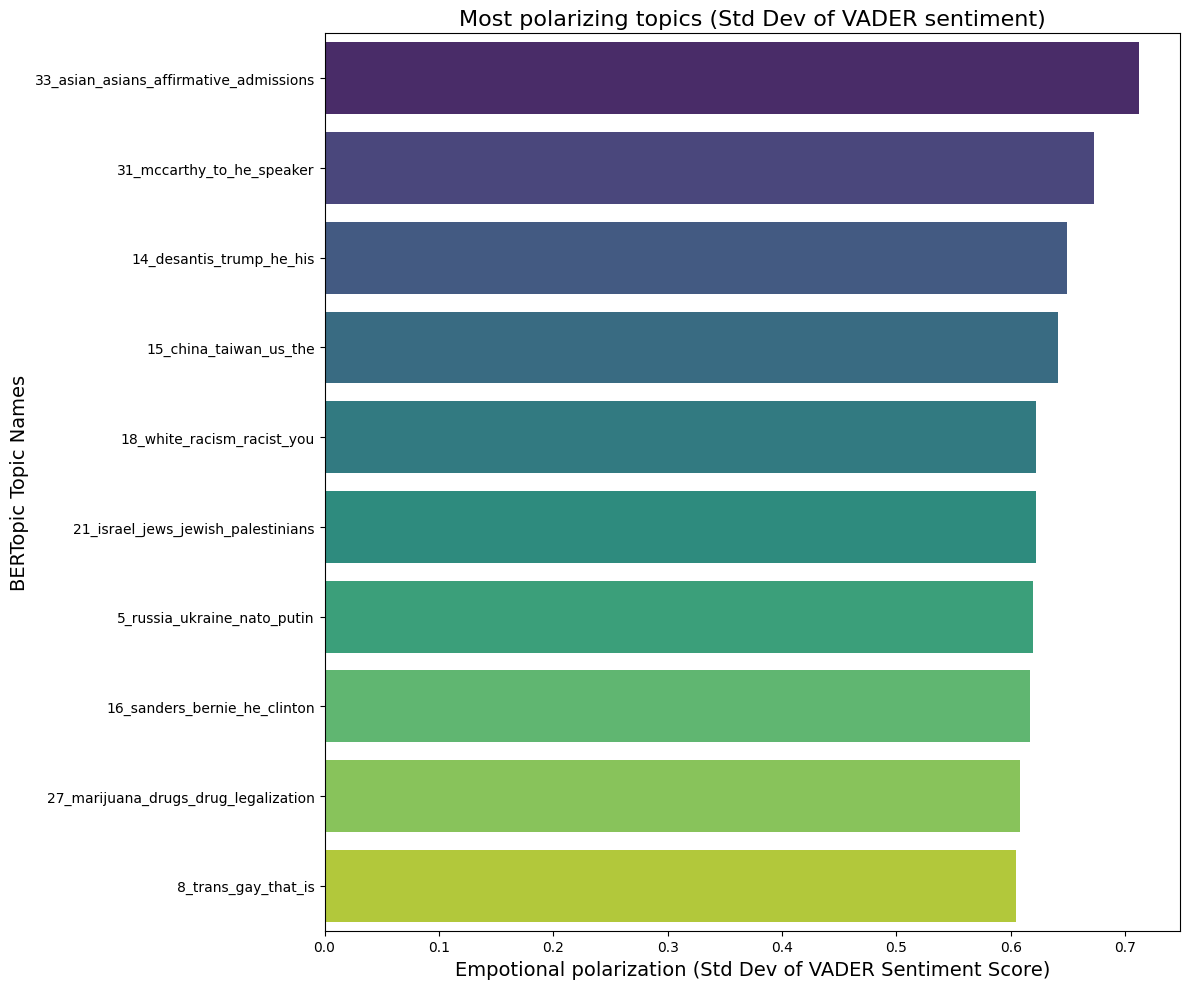

In [102]:
# plot

plt.figure(figsize=(12, 10))
sns.barplot(
    data=polarized_topics.head(10),
    y='Name',
    x='polarization',
    palette='viridis',
)

plt.title('Most polarizing topics (Std Dev of VADER sentiment)', fontsize=16)
plt.xlabel('Empotional polarization (Std Dev of VADER Sentiment Score)', fontsize=14)
plt.ylabel('BERTopic Topic Names', fontsize=14)
plt.tight_layout()
plt.show()